# Blood Glucose Control - EDA

**Name:** Kirpa Chandok



### Import Data

There are multiple data sets each corresponding to a person with diabetes. Please load the files into a single data set while retaining the ability to distinguish between the PWD. 

In [14]:
import pandas as pd
import os 
import glob

pd.options.mode.chained_assignment = None

csv_path = "../data/"
csv_files = glob.glob(os.path.join(csv_path, "*.csv"))


df_list = []

for filename in csv_files: 
    df = pd.read_csv(filename)
    patient_id = os.path.basename(filename).split('.')[0].split('_')[1]
    df["sender_id"] = patient_id
    df_list.append(df)

combined_df = pd.concat(df_list, ignore_index = True)

print(combined_df.head())

                               date sender_id    bgl  bgl_date_millis text  \
0  2024-05-01 00:00:27.029000-05:00    500030  114.0              NaN  NaN   
1  2024-05-01 00:05:27.183000-05:00    500030  117.0              NaN  NaN   
2  2024-05-01 00:10:26.949000-05:00    500030  113.0              NaN  NaN   
3  2024-05-01 00:15:27.180000-05:00    500030  112.0              NaN  NaN   
4  2024-05-01 00:20:27.021000-05:00    500030  113.0              NaN  NaN   

  template msg_type affects_fob affects_iob  dose_units  food_g  \
0      NaN      NaN         NaN         NaN         NaN     NaN   
1      NaN      NaN         NaN         NaN         NaN     NaN   
2      NaN      NaN         NaN         NaN         NaN     NaN   
3      NaN      NaN         NaN         NaN         NaN     NaN   
4      NaN      NaN         NaN         NaN         NaN     NaN   

   food_glycemic_index dose_automatic  fp_bgl  message_basal_change  \
0                  NaN            NaN     NaN            

### Two Data Visualizations

Create at least two visualizations that are of interest to you. They can be things that would be useful information for a PWD to know, or they could be useful for informing future modeling work. If you aren't sure what to visualize try recreating common diabetes data visualizations that you can find on the internet. 

Coming from a family in which Type 2 Diabetes is genetic, my family has been incredibly attentive to our lifestyles to ensure 
good health. Nonetheless, my father, who is diagnosed with T2D, and I, both love coffee. After looking through the data, I noticed 
an instance where patient 500030 took an insulin dosage, then drank coffee around 2 hours later. As such, I wanted to visualize the
changes in their blood glucose levels due to both events. 

Insulin Dosages and Meals


                                   date                       text
118    2024-05-01 09:46:39.884000-05:00                   Dosed 4u
125    2024-05-01 10:18:19.656000-05:00             15g cappuccino
138    2024-05-01 11:18:11.771000-05:00                   Dosed 9u
142    2024-05-01 11:31:32.223000-05:00  40g eggs, toast, mandarin
153    2024-05-01 12:21:09.669000-05:00                   Dosed 5u
...                                 ...                        ...
27676  2024-07-31 19:29:12.298000-05:00                    4g mint
27693  2024-07-31 20:48:29.956000-05:00                   Dosed 6u
27708  2024-07-31 21:53:14.735000-05:00                12g brownie
27711  2024-07-31 22:05:02.095000-05:00                10g brownie
27714  2024-07-31 22:15:12.403000-05:00               12g Gatorade

[1081 rows x 2 columns]
Filtered Target Data


                                  date    bgl       text
1375  2024-05-05 14:06:52.730000-05:00  148.0   Dosed 4u
1376  

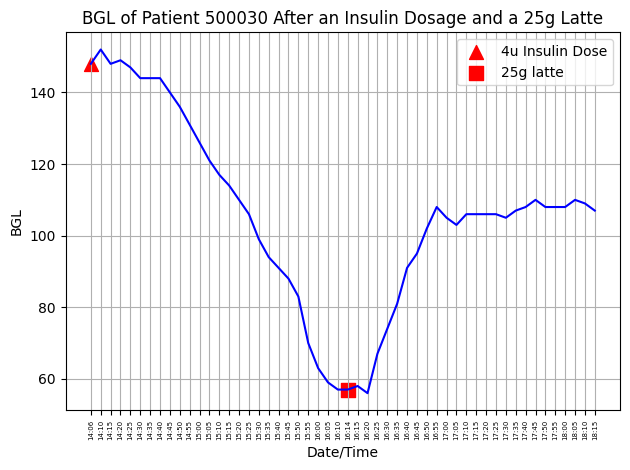

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

df_500030 = combined_df[combined_df['sender_id'] == '500030']

df_meals = df_500030[(df_500030['msg_type'] == 'ANNOUNCE_MEAL') | (df_500030['msg_type'] == 'DOSE_INSULIN')]

def print_data(dataframe, title):
        print(f"{title}\n\n")
        print(dataframe)

print_data(df_meals[['date', 'text']], "Insulin Dosages and Meals")

df_target_data = df_500030[(df_500030['date'] >= '2024-05-05 14:06:52.730000-05:00') & (df_500030['date'] <= '2024-05-05 18:15:44.935000-05:00')]

print_data(df_target_data[['date', 'bgl', 'text']], "Filtered Target Data")

#plotting visualization 1
df_target_data['date'] = pd.to_datetime(df_target_data['date'], errors='coerce')
df_target_data['date'] = df_target_data['date'].dt.strftime('%H:%M') 

insulin_dose = df_target_data[df_target_data['msg_type'] == 'DOSE_INSULIN']

latte_time = df_target_data[df_target_data['text'] == '25g latte']

plt.plot(df_target_data['date'], df_target_data['bgl'], linestyle = '-', color = 'b')


plt.xticks(rotation=90, fontsize = 5)
plt.title("BGL of Patient 500030 After an Insulin Dosage and a 25g Latte")
plt.xlabel("Date/Time")
plt.ylabel("BGL")
plt.grid(True)

plt.scatter(insulin_dose['date'], insulin_dose['bgl'], color = 'r', marker = '^', s = 100, label = '4u Insulin Dose')
plt.scatter(latte_time['date'], latte_time['bgl'], color = 'r', marker = 's', s = 100, label = '25g latte')

plt.legend()
plt.tight_layout()
plt.show()

Using this visualization, we can analyze blood glucose levels after an insulin dosage and drinking a latte. It allows us to see whether or not drinks such as lattes have significant/concerning impacts on bgl. Doing analysis as such can allow patients to reflect on their choices of meals/drinks. Looking at the time it takes for blood glucose levels to lower and rise in response to the insulin dosage and latte can help in seeing the effectiveness of the insulin dosage, and make decisions regarding ideal timings or amounts for insulin to be taken, especially when eating certain foods/drinks such as coffee.

I would extend this visualization to include other instances of drinking coffee, perhaps of different types and sizes. This way we can gain a strong understanding of the effect of coffee on blood glucose levels and perhaps determine which kind of coffee is the least/most impactful.

I also wanted to create a visualization that allowed for a PWD to see whether they are maintaining healthy blood glucose levels, allowing them to make decisions that can enhance their care. I decided this could be done by using the data to figure out the time they spend within a healthy blood glucose level range. This is determined daily over the entire range of the tracking.

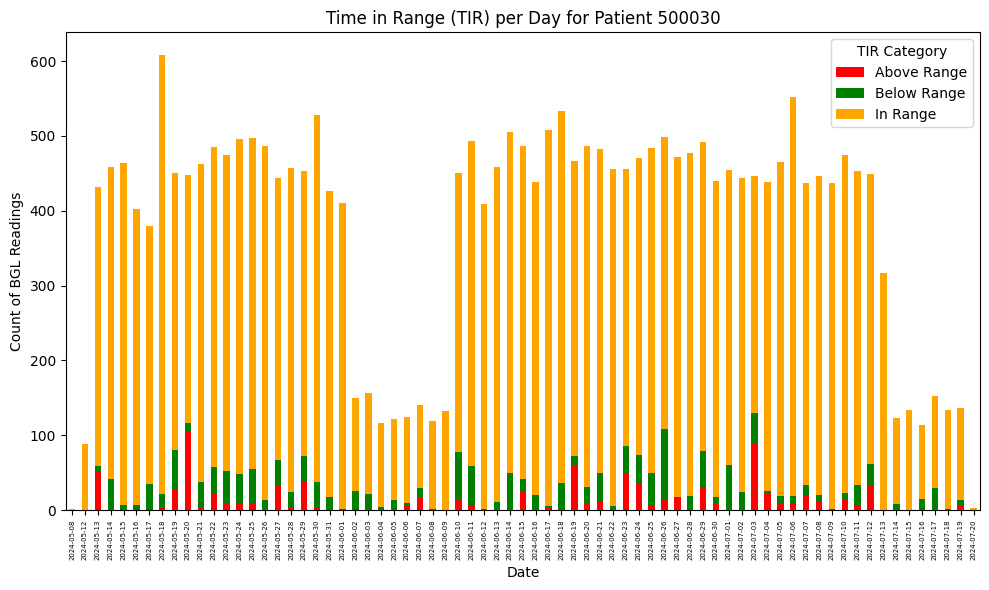

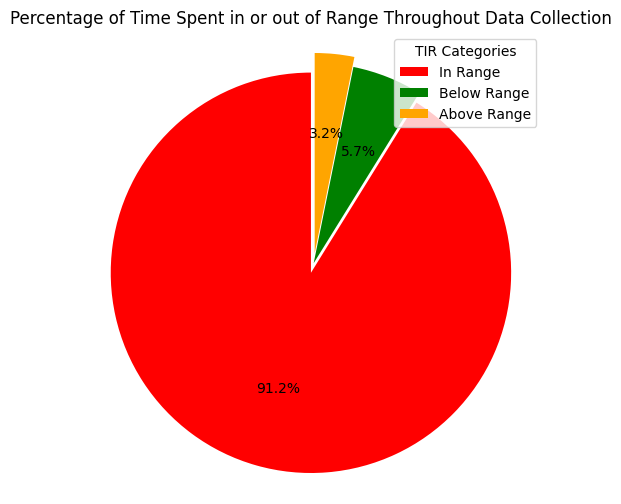

In [16]:
df_500030['date'] = pd.to_datetime(df['date'], errors = 'coerce')
df_500030['date'] = df_500030['date'].dt.date

def TIR_category(bgl):
    if bgl < 70:
        return 'Below Range'
    elif 70 <= bgl <= 180:
        return 'In Range'
    elif bgl <=0: 
        raise ValueError('bgl should be a positive value')
    else:
        return 'Above Range'

df_500030['tir_category'] = df_500030['bgl'].apply(TIR_category)
tir_counts = df_500030.groupby(['date', 'tir_category']).size().unstack(fill_value=0)

tir_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['red', 'green', 'orange'])
plt.title('Time in Range (TIR) per Day for Patient 500030')
plt.xlabel('Date')
plt.ylabel('Count of BGL Readings')
plt.legend(title='TIR Category')
plt.xticks(rotation=90, fontsize = 5)
plt.tight_layout()
plt.show()

total_tir_counts = df_500030['tir_category'].value_counts()

def TIR_percentage(tir_count):
    return (tir_count / tir_count.sum()) * 100

tir_percentages = TIR_percentage(total_tir_counts)

labels = tir_percentages.index
sizes = tir_percentages.values
colors = ['red', 'green', 'orange']

plt.figure(figsize=(6, 6))
plt.pie(sizes, autopct='%1.1f%%', colors=colors, startangle=90, explode=(0.05, 0, 0.05))
plt.legend(labels, title="TIR Categories", loc="upper right")

plt.title('Percentage of Time Spent in or out of Range Throughout Data Collection')
plt.axis('equal')
plt.show()

Using this data, we can monitor whether the PWD has improved in their care of their bgl. As well, since the visualization shows all days of data, we can analyze specific time periods wherein the PWD may have been out of the range for too long and understand the potential causes/reasons. 

I additionally created a pie chart that shows the percentage of time spent in a healthy bgl range throughout all the data collected, which simplifies the data seen in the stacked bar chart. The PWD can use this data to gain a comprehensive understanding of the effectiveness of their care over the period of the data tracking. 

Overall, TIR can be used to see whether a patients diet/lifestyle is successful in maintaining healthy blood glucose levels, and determine if changes are neccesary. Such visualizations provide information regarding long-term blood glucose management, and can be analyzed to create suggestions regarding diabetes care. 

### Ask a question(s) about the data and/or diabetes!
When creating the visualizations you probably had some questions about managing T1D. Ask some questions that might interest you and our diabetes experts will do their best to answer them for you! *Consider this an AMAA about diabetes.* 

1. What factors influence insulin dosage decisions? For example, are decisions based off of specific times during the day whereby insulin sensitivity is higher or lower, or perhaps are decisions based off of meal times?
2. What limitations are there with using meal scoring as a means of evaluating intervention methods and creating suggestions? 

### Final Task

Thanks for showing interest in our project! We plan to incorporate the best/most interesting visualizations into a substack post in the future. 

Please remember to create a pull request with your updated template, don't forget to rename the file to something that we can identify you with, e.g: `eda_[your_name].ipynb`